# Scaling - Nico Keeghan

First I need to find good stars to scale against for each band B, V, and R. Since we have two different exposure times (5 seconds and 60 seconds), I also needed to find a reference image for each exposure time. I did this by looking for images that had the lowest tracking errors, the best focussing, and the smallest amount of cloud.

| Band | Exposure Time | Image |
| --- | --- | --- |
| B | 5  | 3861 |
| B | 60 | 3885 |
| V | 5  | 3862 |
| V | 60 | 3923 |
| R | 5  | 3877 |
| R | 60 | 4095 |

In [1]:
import numpy as np
import astropy
import ccdproc
from ccdproc import CCDData
from photutils import CircularAperture, aperture_photometry
import warnings
import matplotlib.pyplot as plt
import astropy.units as u
warnings.filterwarnings('ignore')

Define the images, bands, and exposure times that we are interested in, and get the relevant filenames.

In [2]:
ref_names = {'B':{5.0:'3861', 60.0:'3885'}, 'V':{5.0:'3862',60.0:'3923'}, 'R':{5.0:'3877', 60.0:'4095'}}
BANDS = ['B','V','R']
EXPTIMES = [5.0,60.0]
ref_fns = ['shift_final/sproc_NGC_3293_{band}_0000{name}.fits'.format(band=band,name=ref_names[band][exp_time]) for band in BANDS for exp_time in EXPTIMES]

Read in the reference images

In [3]:
ref_ims = [CCDData.read(fn) for fn in ref_fns]

Print out the median of each image to see if the background looks good.

In [4]:
for i in range(len(ref_ims)):
    im = ref_ims[i]
    print('band:', im.header['FILTER'])
    print('exposure time:', im.header['EXPTIME'])
    print('median:',np.median(im.data))
    print('-'*30)

band: B
exposure time: 5.0
median: -3.198923
------------------------------
band: B
exposure time: 60.0
median: -9.002777
------------------------------
band: V
exposure time: 5.0
median: -3.795723
------------------------------
band: V
exposure time: 60.0
median: -2.2526855
------------------------------
band: R
exposure time: 5.0
median: -4.2549095
------------------------------
band: R
exposure time: 60.0
median: -0.87371826
------------------------------


This looks like the background subtraction has gone well.

Now we want to find the positions of some bright stars that we will use to scale with. I chose to use 5 stars per image.

I made sure to find stars that weren't close to saturated, and had no nearby stars. The positions I chose are listed below.

5 second exposures: (823, 650), (921, 505), (499, 876), (730, 631), (753, 811)\
60 second exposures: (680,411), (1317,473), (1511,458), (501,883), (937,950)


In [5]:
positions_dict = {'5.0':[(823, 650), (921, 505), (499, 876), (730, 631), (753, 811)], '60.0':[(680,411),(1317,473),(1511,458),(501,883),(937,950)]}

I then displayed all of the images with circles marked around the identified positions to make sure that the stars are correctly located, and to check that I have chosen good images. Most of the images displayed here all look good - the stars are correctly located and there aren't any neighbouring stars. However, in the R-band 60 second exposure the star at (501,883) has some close stars only visible in the R-band, so for the 60 second R-band image we will replace this star with the star at (1517,714), which is bright in the R-band.

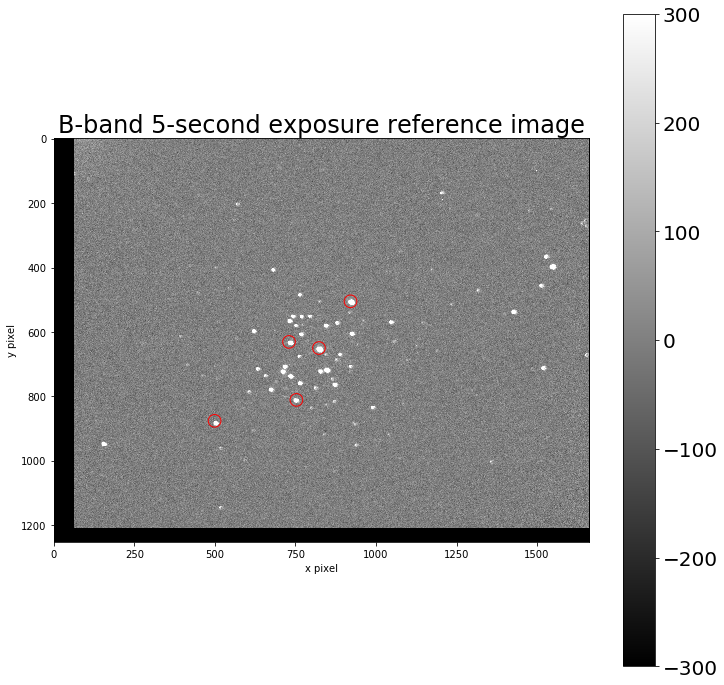

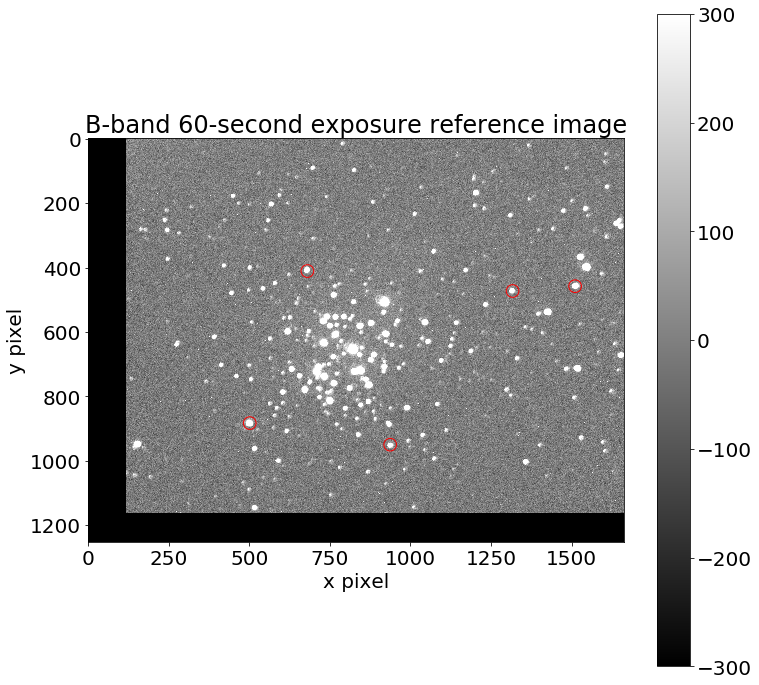

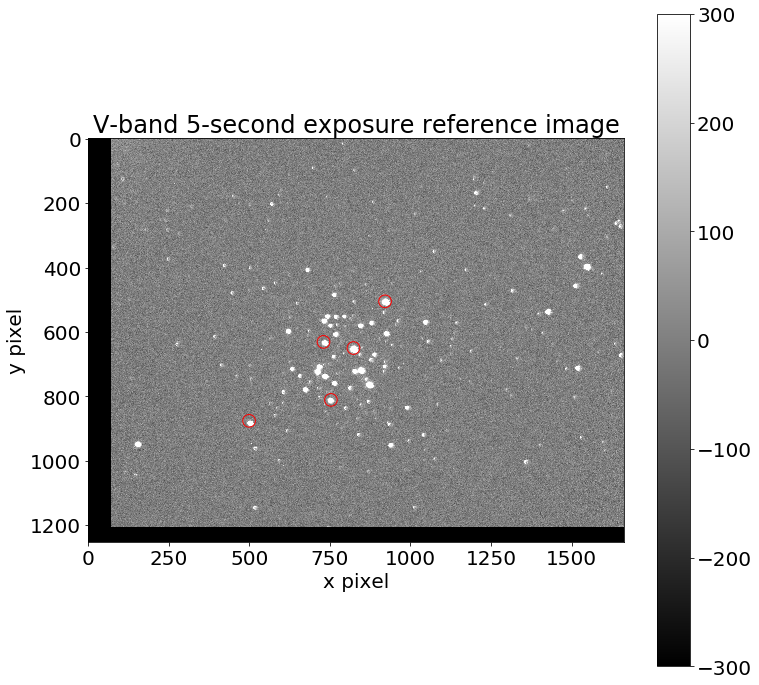

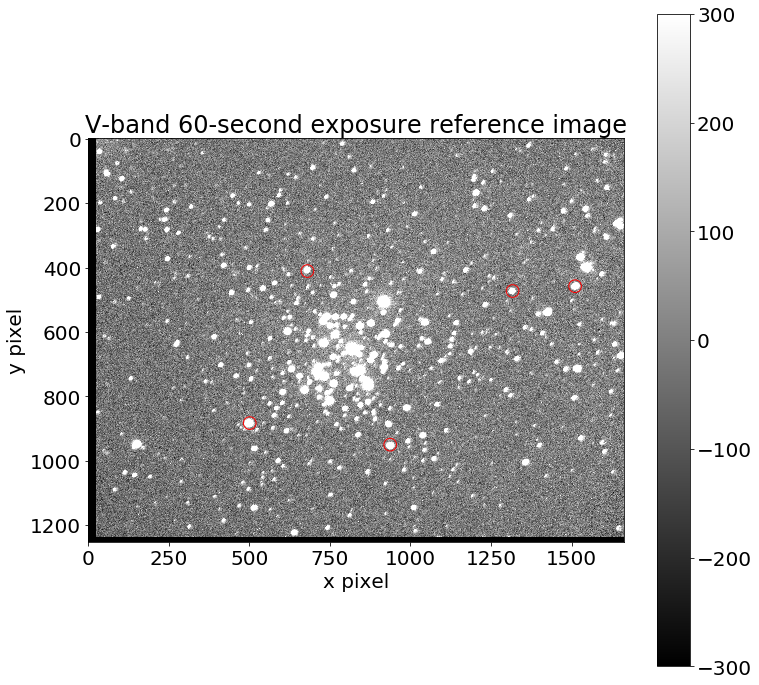

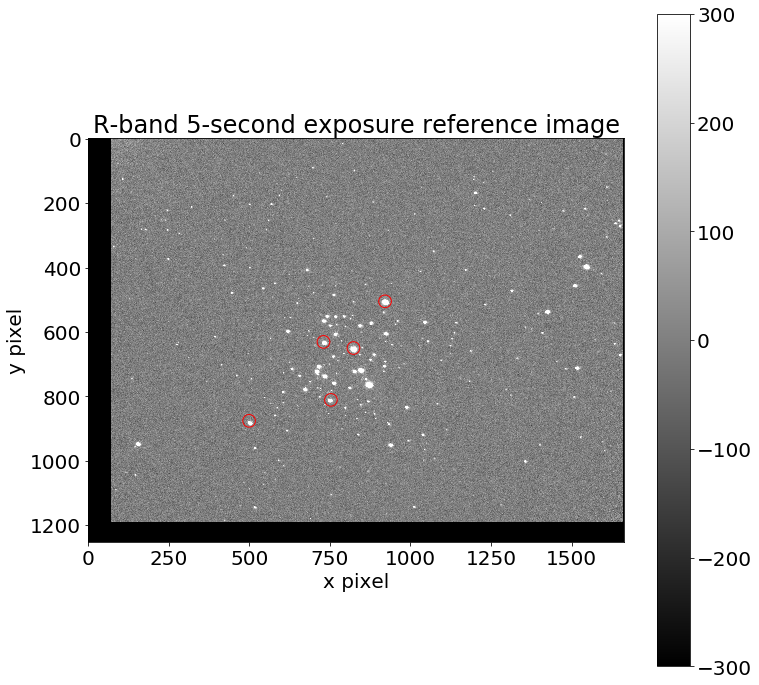

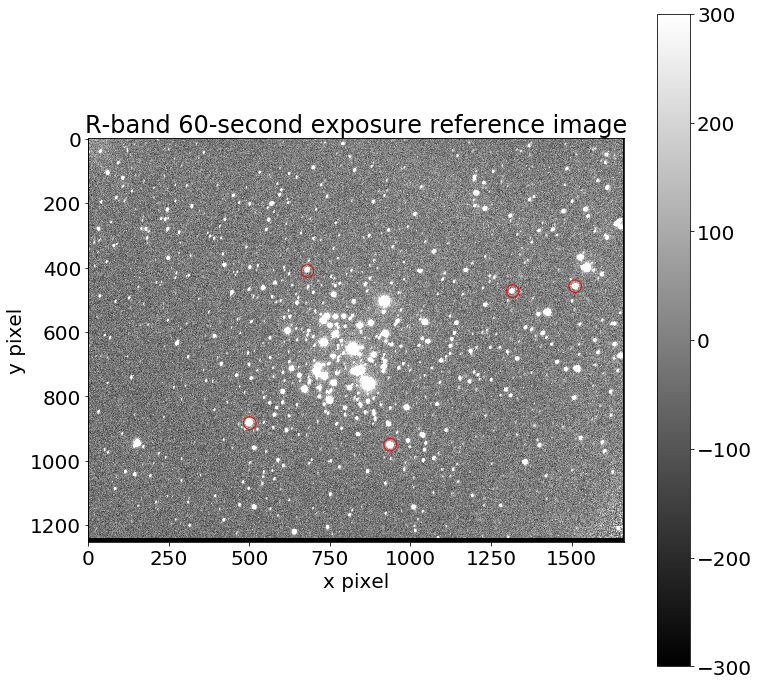

In [6]:
for im in ref_ims:
    exptime = im.header['EXPTIME']
    band = im.header['FILTER']
    positions = positions_dict[str(exptime)]
    fig, ax = plt.subplots(figsize = (12,12))

    plt.rcParams.update({'font.size': 20})
    plt.imshow(im, cmap='gray', vmin=-300, vmax=300)  # used rough vmin and vmax from min and max of zscale in ds9 
    plt.xlabel('x pixel')
    plt.ylabel('y pixel')
    plt.title('%s-band %.0f-second exposure reference image' % (band, exptime))
    plt.colorbar()

    for position in positions:
        plt.scatter(position[0], position[1], s=160, facecolor='none',edgecolor='red')

    plt.show()
    plt.close()

In [7]:
# define the new positions
positions_dict = {'B':{'5.0':[(823, 650), (921, 505), (499, 876), (730, 631), (753, 811)], '60.0':[(680,411),(1317,473),(1511,458),(501,883),(937,950)]},'V':{'5.0':[(823, 650), (921, 505), (499, 876), (730, 631), (753, 811)], '60.0':[(680,411),(1317,473),(1511,458),(501,883),(937,950)]},'R':{'5.0':[(823, 650), (921, 505), (499, 876), (730, 631), (753, 811)], '60.0':[(680,411),(1317,473),(1511,458),(1517,714),(937,950)]}}

I displayed the 60 second R-band image below, and the new selection looks good.

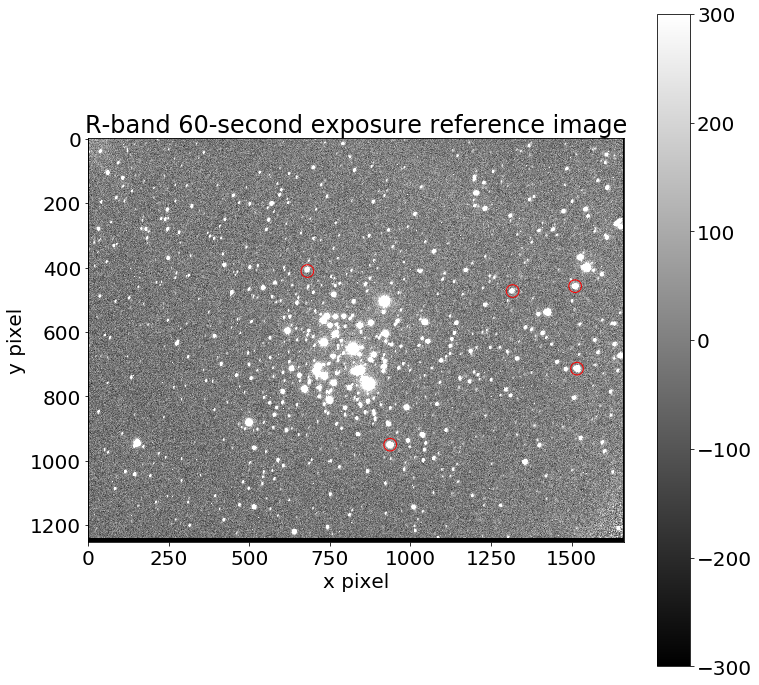

In [8]:
for im in ref_ims[-1:]:
    exptime = im.header['EXPTIME']
    band = im.header['FILTER']
    positions = positions_dict[band][str(exptime)]
    fig, ax = plt.subplots(figsize = (12,12))

    plt.rcParams.update({'font.size': 20})
    plt.imshow(im, cmap='gray', vmin=-300, vmax=300)
    plt.xlabel('x pixel')
    plt.ylabel('y pixel')
    plt.title('%s-band %.0f-second exposure reference image' % (band, exptime))
    plt.colorbar()

    for position in positions:
        plt.scatter(position[0], position[1], s=160, facecolor='none',edgecolor='red')

    plt.show()
    plt.close()

Now to get to the scaling. Below I have written a function to get the photometry tables for the images and to print the scaling ratios.

In [9]:
def scale_phot_tables(ref_im, positions, radius, scim):
    apertures = CircularAperture(positions, r=radius)

    phot_table = aperture_photometry(ref_im, apertures)
    
    print('Reference Image:')
    print(phot_table)
    
    
    print('Other Images:')
    phot_tables=[phot_table] # initialise list to store photometry tables, with first index the reference image
    for idx, thisimage in enumerate(scim):  # loop through images in scim
        this_phot_table = aperture_photometry(thisimage, apertures) # photometry table for current image
        # print the current index/image number
        print(idx)
        # divide the list of counts in each aperture for the reference image by the current image
        print(phot_table['aperture_sum']/this_phot_table['aperture_sum'])
        # find the median ratio between the reference image and the current image of all of the apertures
        print(np.ma.median(phot_table['aperture_sum']/this_phot_table['aperture_sum']))
        
        # append the photometry table for this star to the photometry table
        phot_tables.extend([this_phot_table])
        
    return phot_tables

We start by loading in all of the shifted images, and then sorting them by exposure time and filter (band).

In [10]:
images = ccdproc.ImageFileCollection("./shift_final/",glob_include='sproc_NGC_3293*')

filenames = {
    band : {str(exptime) : (images.files_filtered(EXPTIME = exptime, FILTER = band)) for exptime in EXPTIMES}
    for band in BANDS
}

# print to check that the filenames have been found correctly
print(filenames)

{'B': {'5.0': array(['sproc_NGC_3293_B_00003852.fits', 'sproc_NGC_3293_B_00003853.fits',
       'sproc_NGC_3293_B_00003854.fits', 'sproc_NGC_3293_B_00003855.fits',
       'sproc_NGC_3293_B_00003856.fits', 'sproc_NGC_3293_B_00003857.fits',
       'sproc_NGC_3293_B_00003858.fits', 'sproc_NGC_3293_B_00003859.fits',
       'sproc_NGC_3293_B_00003860.fits', 'sproc_NGC_3293_B_00003861.fits'],
      dtype='<U30'), '60.0': array(['sproc_NGC_3293_B_00003885.fits', 'sproc_NGC_3293_B_00003886.fits',
       'sproc_NGC_3293_B_00003889.fits', 'sproc_NGC_3293_B_00003890.fits',
       'sproc_NGC_3293_B_00003942.fits', 'sproc_NGC_3293_B_00003943.fits',
       'sproc_NGC_3293_B_00003946.fits', 'sproc_NGC_3293_B_00003947.fits',
       'sproc_NGC_3293_B_00003950.fits', 'sproc_NGC_3293_B_00003951.fits'],
      dtype='<U30')}, 'V': {'5.0': array(['sproc_NGC_3293_V_00003862.fits', 'sproc_NGC_3293_V_00003863.fits',
       'sproc_NGC_3293_V_00003864.fits', 'sproc_NGC_3293_V_00003865.fits',
       'sproc_NGC_32

Now we read all of the images using these filenames.

In [11]:
scims = {
    band : {str(exptime) :
[ CCDData.read("./shift_final/" + fn, unit = "adu") for fn in filenames[band][str(exptime)]]
    for exptime in EXPTIMES}
    for band in BANDS
}

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


Finally, we use the function we defined to get the photometry tables for all of these images.

In [12]:
# sort reference images according to band and exposure time
ref_ims_dict = {}
for im in ref_ims:
    # get band and exposure time for image
    band = im.header['FILTER']
    exptime = str(im.header['EXPTIME'])
    
    # add band to dictionary if not already included
    if band not in ref_ims_dict.keys():
        ref_ims_dict[band] = {}
      
    # add image to dictionary
    ref_ims_dict[band][exptime] = im

# use scale_phot_tables function
phot_tables = {band :
    {str(exptime) : scale_phot_tables(ref_ims_dict[band][str(exptime)], positions_dict[band][str(exptime)],20,scims[band][str(exptime)])
     for exptime in EXPTIMES}
    for band in BANDS
}

Reference Image:
 id xcenter ycenter    aperture_sum   
      pix     pix          adu        
--- ------- ------- ------------------
  1   823.0   650.0 1510243.8262188332
  2   921.0   505.0 1170760.2508559432
  3   499.0   876.0  263911.2241228623
  4   730.0   631.0  360478.3539261837
  5   753.0   811.0  219243.7996548132
Other Images:
0
[1.00470278 0.99507059 1.00785565 0.98594654 0.99906906]
0.9990690580473756
1
[0.99030618 0.98826936 0.98576099 0.99102206 1.01674323]
0.9903061768432153
2
[1.00209608 0.99944082 1.00258197 0.98468539 1.00307027]
1.0020960767514104
3
[1.00149492 0.99173338 1.00943287 0.99710705 1.01130994]
1.0014949176351275
4
[1.00365759 1.00380727 1.02443525 0.9820453  1.03224455]
1.003807272048187
5
[1.00902507 0.99477176 1.01565864 0.99154989 1.00892802]
1.008928024956512
6
[1.00350503 0.99094195 1.01987675 0.99248302 1.02982704]
1.003505028317469
7
[0.99688566 0.9997374  1.01837323 1.00124046 1.00847606]
1.0012404608517695
8
[1.00087265 0.99217617 1.02496054 

When these scalings are much larger than 1, we know that these images are very dim compared to the reference image, probably due to cloud which we faced during our observation night. We want to exclude these images from our analysis.

These images include:

B-band 60 second exposure images 8 (scaling 6.9) and 9 (scaling 4.9)\
R-band 60 second exposure images 2 (scaling 2.7) and 3 (scaling 3.5)

All of the other scalings look acceptable.

Unfortunately we only have 6 60-second R-band exposures. I had a look at the images with large scaling factors in ds9 and the impact of cloud is very clear, with many stars not visible in these images that were present in the expossures that weren't obstructed by cloud. I believe that the inclusion of these images will be too detrimental to our analysis because of this, so we will exclude these from our combined image.

# Combine

I chose to perform a median combine on the images, since using a median combine instead of an average combine accounts for outliers. Another possibility is to do an average combine with min max rejection, however since we only have 4 images in one of our bands this is not a great option.

In [13]:
# band, exposure time, image index to exclude
exclude = [('B','60.0',8),('B','60.0',9),('R','60.0',2),('R','60.0',3)]

for band in BANDS:
    for exptime in EXPTIMES:
        print(band, exptime)
        scim = scims[band][str(exptime)]
        phot_table = phot_tables[band][str(exptime)]
        thisscim = []
        for idx, thisimage in enumerate(scim):
            # exclude the images we don't to use
            if (band,str(exptime),idx) not in exclude:
                m = np.ma.median(phot_table[0]['aperture_sum'] / phot_table[idx+1]['aperture_sum'])
                print(m)
                thisscim.append(scim[idx].multiply(m))

        sci_median = ccdproc.combine(thisscim, method = 'median',dtype = np.float32, 
                                     minmax_clip = True, minmax_clip_min = -500)
        sci_median.write("combined_ims/NGC_3293_%s_%.0f_median.fits" % (band,exptime))

B 5.0
0.9990690580473756
0.9903061768432153
1.0020960767514104
1.0014949176351275
1.003807272048187
1.008928024956512
1.003505028317469
1.0012404608517695
1.000872653275652
1.0
B 60.0
1.0
1.0010141347754378
1.061486226285915
0.9959851897815944
0.9808717637778667
0.9895703181941818
0.993927015041846
0.998413168092128
V 5.0
1.0
1.0015549032450966
0.9987792881772043
1.0053579617499988
0.9946386281738273
1.0020193666735855
0.9997300242009224
0.9875429723063257
0.9994433711392147
0.995783802150508
V 60.0
1.019971621445234
1.0
0.9855877205232259
0.9930125490633059
1.2269857406714455
1.1076900609597453
1.3738315048515497
1.4485951911217938
1.5190544633175138
R 5.0
1.006876620999285
1.001492854563377
1.007234808781827
1.0104699323650805
1.0034778573758725
1.0
0.9961796003704947
0.9987615408367768
1.0251327111259365
1.0098528760298213
R 60.0
0.962010392954056
0.9551949699223525
1.005315594753036
1.0


The printed scalings assure us that we have included the correct images, and that we have gone through all of the bands and exposure times that we were interested in. The scaling and combining is complete! I viewed the images in ds9 and the images look to have been combined correctly.